# LSA

© Anatolii Stehnii, 2018

Main goal of this assignment is to give you a basic understanding of how Latent Semantic Analysis is performed and how to interpret it results. In this work you will calculate word embeddings using LSA for arbitrary text and explore their properties.

Code from [Yuri Guts's Thrones2Vec](https://github.com/YuriyGuts/thrones2vec/blob/master/Thrones2Vec.ipynb) is used.

In [1]:
%env LC_ALL=en_US.UTF-8
%env LANG=en_US.UTF-8

import nltk
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

env: LC_ALL=en_US.UTF-8
env: LANG=en_US.UTF-8


## Corpus preprocessing

First, select any text and download it into folder `./data/lab1` in `txt` format. I recommend you to use English text, but if you feel brave enough, you can setup a pipleline for any other language.

In [2]:
book_filenames = glob.glob("../data/lab1/*.txt")
print("Found books: \n{}".format('\n'.join(book_filenames)))

Found books: 
../data/lab1/001ssb.txt
../data/lab1/002ssb.txt
../data/lab1/003ssb.txt
../data/lab1/004ssb.txt
../data/lab1/005ssb.txt


In [3]:
corpus  = ""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with open(book_filename, "r", ) as f:
        corpus += f.read()
    print("Corpus is now {0} characters long.\n".format(len(corpus)))

Reading '../data/lab1/001ssb.txt'...
Corpus is now 1607894 characters long.

Reading '../data/lab1/002ssb.txt'...
Corpus is now 3392960 characters long.

Reading '../data/lab1/003ssb.txt'...
Corpus is now 5714229 characters long.

Reading '../data/lab1/004ssb.txt'...
Corpus is now 7437782 characters long.

Reading '../data/lab1/005ssb.txt'...
Corpus is now 9749792 characters long.



We need to split our corpus on documents and split document on terms. Use English tokenizers from NLTK or create your own function.

In [4]:
nltk.download("punkt")
nltk_english = nltk.data.load('tokenizers/punkt/english.pickle')
document_tokenize = lambda corpus: nltk_english.tokenize(corpus)

from nltk import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
documents_raw = document_tokenize(corpus)
documents = list(map(word_tokenize, documents_raw))

Add your preprocessing if needed or use default:

In [20]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def preprocess(word):
    clean = re.sub("[^a-zA-Z]","", word)
    clean_lower = clean.lower()
    return ps.stem(clean_lower)

documents = [[preprocess(word) for word in document] for document in documents]
documents = [[word for word in document if word] for document in documents]

In [21]:
print(documents_raw[5])
print(documents[5])

He was an old man, past fifty, and he had seen the lordlings come and go.
['he', 'wa', 'an', 'old', 'man', 'past', 'fifti', 'and', 'he', 'had', 'seen', 'the', 'lordl', 'come', 'and', 'go']


In [22]:
token_count = sum([len(document) for document in documents])
print("The corpus contains {0:,} tokens in {1:,} documents".format(token_count, len(documents)))

The corpus contains 1,807,788 tokens in 158,737 documents


Define your threshold for a minimum word occurence in the text to filter rare words.

In [23]:
# Minimum word count threshold.
min_word_count = 3

vocab = {}
for d in documents:
    for w in d:
        if w in vocab:
            vocab[w] += 1
        else:
            vocab[w] = 1

rare_words = {w for w, count in vocab.items() if count < min_word_count}
print("The corpus contains {0:,} unique words, {1:,} with less than {2:} occurences.".format(len(vocab), len(rare_words), min_word_count))

The corpus contains 16,279 unique words, 6,114 with less than 3 occurences.


Define your own set of stop words or use default from NLTK:

In [24]:
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anatolii.stehnii/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
stop_words = set()
remove_words = rare_words | stop_words
documents = [[word for word in document if word not in remove_words] for document in documents]

print(documents[5])
all_words = {word for document in documents for word in document}
print("A filtered corpus contains {} unique words".format(len(all_words)))

['he', 'wa', 'an', 'old', 'man', 'past', 'fifti', 'and', 'he', 'had', 'seen', 'the', 'lordl', 'come', 'and', 'go']
A filtered corpus contains 10165 unique words


## Term-document matrix

Here you need to transform your corpus into term-document matrix of any type you want (BoW, TF-IDF). Use a sparse matrix, if you have large amount of data. Don't forget to save your vocabulary so you can restore a row index for each word.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
documents_raw_join = [' '.join(words) for words in documents]
td_matrix = vectorizer.fit_transform(documents_raw_join)
vocab = vectorizer.get_feature_names()

## SVD

Perform SVD of term-document matrix and reduce it's dimensionality to n_dim components. 

In [70]:
n_dim = 100

In [78]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_dim)
u = svd.fit_transform(td_matrix)

In [85]:
word_ebeddings = u

## Explore result

Select a set of words you would like to explore.

In [86]:
words = ['he', 'she', 'king', 'queen', 'man', 'woman', 'warrior', 'bold', 'reckless', 'furious', 'stupid', 'daeneri', 'cersei', 'lannist', 'lord']
indexes = [vocab.index(word) for word in words]

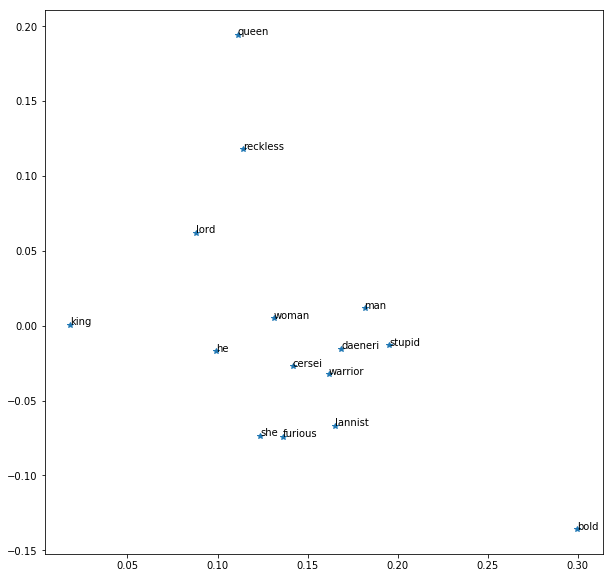

In [87]:
plt.figure()
coordinates  = [word_ebeddings[i,0:2] for i in indexes]
xdata, ydata = zip(*coordinates)
plt.plot(xdata, ydata, '*')
for c, word in zip(coordinates, words):
    plt.text(c[0], c[1], word)
plt.show()

---
(Optional): Change document window from sentence to 5-gram.

In [92]:
from scipy import spatial
import itertools

words = ['cersei', 'stanni', 'he', 'she', 'man', 'woman']

for w1, w2 in itertools.combinations(words, 2):
    v1 = word_ebeddings[vocab.index(w1)]
    v2 = word_ebeddings[vocab.index(w2)]
    print('Distance for words {} and {}: {}'.format(w1, w2, spatial.distance.cosine(v1, v2)))

Distance for words cersei and stanni: 0.8871860664799975
Distance for words cersei and he: 0.9505277237587815
Distance for words cersei and she: 0.7610019203874365
Distance for words cersei and man: 0.7419671768977856
Distance for words cersei and woman: 0.9703350944842281
Distance for words stanni and he: 0.7648603987063753
Distance for words stanni and she: 0.8950543945211512
Distance for words stanni and man: 0.7682429755257292
Distance for words stanni and woman: 0.5471424131837864
Distance for words he and she: 1.0005549005837764
Distance for words he and man: 0.9531103644384229
Distance for words he and woman: 0.8532404391150494
Distance for words she and man: 0.6350982091221241
Distance for words she and woman: 0.8986829313189408
Distance for words man and woman: 0.7874113141261043


In [76]:
for document in documents:
    if 'cersei' in document: 
        print(document)


['page', 'cersei', 'and', 'the', 'children', 'travel', 'with', 'them']
['robert', 's', 'queen', 'cersei', 'lannist', 'enter', 'on', 'foot', 'with', 'her', 'younger', 'children']
['cersei', 'wa', 'furiou']
['ser', 'jaim', 'lannist', 'wa', 'twin', 'to', 'queen', 'cersei', 'tall', 'and', 'golden', 'with', 'flash', 'green', 'eye', 'and', 'a', 'smile', 'that', 'cut', 'like', 'a', 'knife']
['all', 'that', 'the', 'god', 'had', 'given', 'to', 'cersei', 'and', 'jaim', 'they', 'had', 'deni', 'tyrion']
['jaim', 'sat', 'at', 'tabl', 'with', 'cersei', 'and', 'the', 'children', 'talk', 'in', 'low', 'hush', 'voic']
['cersei', 'wa', 'studi', 'him', 'warili']
['the', 'glanc', 'that', 'pass', 'between', 'jaim', 'and', 'cersei', 'last', 'no', 'more', 'than', 'a', 'second', 'but', 'he', 'did', 'not', 'miss', 'it']
['if', 'he', 'wake', 'cersei', 'repeat']
['not', 'near', 'soon', 'enough', 'cersei', 'said']
['cersei', 'stood', 'abruptli']
['i', 'promis', 'you', 'if', 'that', 'wretch', 'thing', 'break', 'ano

['cersei', 'had', 'learn', 'suspicion', 'at', 'her', 'father', 's', 'knee', 'thi', 'could', 'well', 'be', 'some', 'trap', 'a', 'lie', 'meant', 'to', 'sow', 'discord', 'between', 'the', 'lion', 'and', 'the', 'rose']
['she', 'gave', 'testimoni', 'at', 'tyrion', 's', 'trial', 'cersei', 'recal', 'suddenli']
['they', 'will', 'have', 'him', 'stumbl', 'and', 'shuffl', 'like', 'a', 'fool', 'by', 'the', 'time', 'they', 're', 'done', 'cersei', 'thought', 'resent', 'as', 'she', 'watch']
['they', 'could', 'be', 'twin', 'cersei', 'thought', 'as', 'she', 'watch', 'them']
['cersei', 'refus', 'mace', 'tyrel', 'as', 'well', 'and', 'later', 'lancel']
['lord', 'and', 'ladi', 'cersei', 'call', 'out', 'loudli', 'if', 'you', 'will', 'be', 'so', 'good', 'as', 'to', 'come', 'outsid', 'with', 'me', 'we', 'shall', 'light', 'a', 'candl', 'to', 'celebr', 'the', 'union', 'of', 'highgarden', 'and', 'casterli', 'rock', 'and', 'a', 'new', 'age', 'of', 'peac', 'and', 'plenti', 'for', 'our', 'seven', 'kingdom']
['when'